In [67]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import tqdm

myseed = 12345
torch.manual_seed(myseed)
torch.random.manual_seed(myseed)
random.seed(0)
np.random.seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(myseed)
torch.autograd.set_detect_anomaly(True)  # 可在NaN 出现时报错，定位错误代码。正向传播时：开启自动求导的异常侦测
# 反向传播时：在求导时开启侦测
#with torch.autograd.detect_anomaly():
#    loss.backward()
torch.multiprocessing.set_sharing_strategy('file_system')

In [68]:
# 使用 GPU
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [69]:
# 数据预处理, 调整图片大小
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize([96, 96])])

# 下载Fashion-MNIST训练集数据，并构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序
trainset = torchvision.datasets.FashionMNIST('dataset/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 下载Fashion-MNIST测试集数据，并构建测试集数据载入器trainloader,每次从测试集中载入64张图片，每次载入都打乱顺序
testset = torchvision.datasets.FashionMNIST('dataset/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [70]:
class Residual(torch.nn.Module):
    def __init__(self, input_channals, num_channels, use_1x1conv = False, strides = 1):
        super(Residual, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_channals, num_channels, kernel_size=3, stride=strides, padding=1),
            torch.nn.BatchNorm2d(num_channels)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(num_channels)
        )
        self.use_1x1conv = False
        if use_1x1conv:
            self.oneConv = torch.nn.Conv2d(input_channals, num_channels, kernel_size=1, stride=strides)
            self.use_1x1conv = True
    
    def forward(self, x):
        Y = torch.nn.functional.relu(self.layer1(x))
        Y = self.layer2(Y)
        if self.use_1x1conv:
            x = self.oneConv(x)
        Y = x + Y
        return torch.nn.functional.relu(Y)

In [71]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        )
        self.layer2 = torch.nn.Sequential(
            Residual(64, 64, True, 2),
            Residual(64, 64, False),
        )
        self.layer3 = torch.nn.Sequential(
            Residual(64, 128, True, 2),
            Residual(128, 128, False),
        )
        self.layer4 = torch.nn.Sequential(
            Residual(128, 256, True, 2),
            Residual(256, 256, False),
        )
        self.layer5 = torch.nn.Sequential(
            Residual(256, 512, True, 2),
            Residual(512, 512, False),
        )
        self.layer6 = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten(), 
            torch.nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

In [72]:
model = ResNet()
model = model.to(device=try_gpu())

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

model.train()
epochs= 1

Loss_data = {
    "train": [],
    "dev": []
}

for epoch in tqdm.tqdm(range(epochs)):
    Loss = 0
    for batch_x, batch_y in trainloader:
        batch_x, batch_y = batch_x.to(device=try_gpu()), batch_y.to(device=try_gpu())
        prediction = model(batch_x)
        loss = criterion(prediction, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        Loss_data["train"].append(float(loss))
        Loss_data["dev"].append(0)

  0%|          | 0/1 [00:00<?, ?it/s]/home/songzihui/miniconda3/envs/d2l/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 1/1 [03:54<00:00, 234.87s/it]


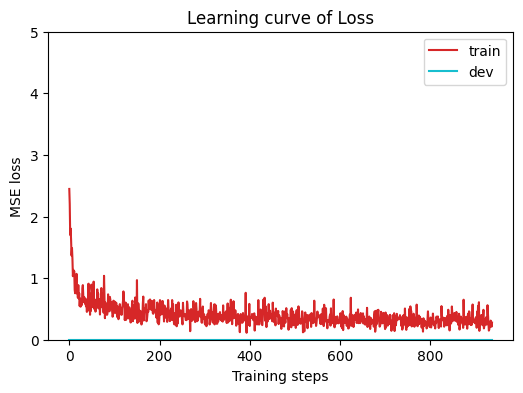

In [73]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
    
plot_learning_curve(Loss_data, "Loss")

In [75]:
model.eval()
predicted_labels = []
epoch = 0
accuracy_sum = 0
with torch.no_grad():
    for batch_x, batch_y in testloader:
        batch_x, batch_y = batch_x.to(device = try_gpu()), batch_y.to(device = try_gpu())
        prediction = model(batch_x)
        predicted_label = torch.argmax(prediction,1)
        accuracy = torch.eq(batch_y, predicted_label).float().mean()
        accuracy_sum += accuracy
        epoch = epoch + 1

print("准确率: %f" % (accuracy_sum / epoch))

准确率: 0.889232
